In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')


def extract_group_expr(sample):
    parts = sample.split('_')
    if len(parts) >= 3:
        return f"{parts[1]}_{parts[2]}"
    return "Unknown"

def extract_group_oxid(sample):
    parts = sample.split('_')
    if len(parts) >= 5:
        return f"{parts[2]}_{parts[3]}"
    return "Unknown"

def load_data(EXPR_PATH, OXID_PATH):
    print("Loading expression data...")
    expr_df = pd.read_csv(EXPR_PATH)
    
    print("Loading oxidation data...")
    oxid_df = pd.read_csv(OXID_PATH)
    
    expr_df['Group'] = expr_df['Sample'].apply(extract_group_expr)
    oxid_df['Group'] = oxid_df['sample'].apply(extract_group_oxid)
    
    print("Expression data shape:", expr_df.shape)
    print("Oxidation data shape:", oxid_df.shape)
    
    return expr_df, oxid_df

def merge_data_for_correlation(expr_df, oxid_df):
    # Simple gene column detection - just look for 'gene' or 'Gene'
    gene_col_expr = 'Gene'
    gene_col_oxid = 'gene'

    print(f"Using gene column '{gene_col_expr}' from expression data")
    print(f"Using gene column '{gene_col_oxid}' from oxidation data")
    
    # Prepare data for merging
    expr_for_merge = expr_df[[gene_col_expr, 'Sample', 'Group', 'Expression_level']].copy()
    expr_for_merge.rename(columns={gene_col_expr: 'Gene'}, inplace=True)
    
    oxid_for_merge = oxid_df[[gene_col_oxid, 'sample', 'Group', 'median_normalized_damage']].copy()
    oxid_for_merge.rename(columns={gene_col_oxid: 'Gene', 'sample': 'Sample'}, inplace=True)
    
    # Merge datasets
    merged_df = pd.merge(expr_for_merge, oxid_for_merge, on=['Gene', 'Group'], 
                        suffixes=('_expr', '_oxid'), how='inner')
    
    print(f"Merged data shape: {merged_df.shape}")
    print("Groups found:", merged_df['Group'].unique())
    
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')


def extract_group_expr(sample):
    parts = sample.split('_')
    if len(parts) >= 3:
        return f"{parts[1]}_{parts[2]}"
    return "Unknown"

def extract_group_oxid(sample):
    parts = sample.split('_')
    if len(parts) >= 5:
        return f"{parts[2]}_{parts[3]}"
    return "Unknown"

def load_data(EXPR_PATH, OXID_PATH):
    print("Loading expression data...")
    expr_df = pd.read_csv(EXPR_PATH)
    
    print("Loading oxidation data...")
    oxid_df = pd.read_csv(OXID_PATH)
    
    expr_df['Group'] = expr_df['Sample'].apply(extract_group_expr)
    oxid_df['Group'] = oxid_df['sample'].apply(extract_group_oxid)
    
    print("Expression data shape:", expr_df.shape)
    print("Oxidation data shape:", oxid_df.shape)
    
    return expr_df, oxid_df

def merge_data_for_correlation(expr_df, oxid_df):
    # Simple gene column detection - just look for 'gene' or 'Gene'
    gene_col_expr = 'Gene'
    gene_col_oxid = 'gene'

    print(f"Using gene column '{gene_col_expr}' from expression data")
    print(f"Using gene column '{gene_col_oxid}' from oxidation data")
    
    # Prepare data for merging
    expr_for_merge = expr_df[[gene_col_expr, 'Sample', 'Group', 'Expression_level']].copy()
    expr_for_merge.rename(columns={gene_col_expr: 'Gene'}, inplace=True)
    
    oxid_for_merge = oxid_df[[gene_col_oxid, 'sample', 'Group', 'median_normalized_damage']].copy()
    oxid_for_merge.rename(columns={gene_col_oxid: 'Gene', 'sample': 'Sample'}, inplace=True)
    
    # Merge datasets
    merged_df = pd.merge(expr_for_merge, oxid_for_merge, on=['Gene', 'Group'], 
                        suffixes=('_expr', '_oxid'), how='inner')
    
    print(f"Merged data shape: {merged_df.shape}")
    print("Groups found:", merged_df['Group'].unique())
    
    return merged_df

def analyze_zero_inflation_detailed(merged_df):
    """
    Detailed analysis of zero inflation patterns for expression data
    """
    print("\n" + "="*80)
    print("DETAILED ZERO INFLATION ANALYSIS")
    print("="*80)
    
    analysis_results = {}
    
    for group in merged_df['Group'].unique():
        group_data = merged_df[merged_df['Group'] == group]
        
        # Basic zero inflation stats
        total_points = len(group_data)
        zero_points = len(group_data[group_data['Expression_level'] == 0])
        zero_percentage = (zero_points / total_points) * 100
        
        # Expression distribution analysis
        expr_vals = group_data['Expression_level']
        
        print(f"\nGroup: {group}")
        print(f"Total data points: {total_points:,}")
        print(f"Zero expression points: {zero_points:,}")
        print(f"Zero inflation: {zero_percentage:.1f}%")
        print(f"Expression range: {expr_vals.min():.2f} - {expr_vals.max():.2f}")
        print(f"Expression mean: {expr_vals.mean():.2f}")
        
        # Oxidation damage distribution
        oxid_vals = group_data['median_normalized_damage']
        print(f"Oxidation range: {oxid_vals.min():.4f} - {oxid_vals.max():.4f}")
        print(f"Oxidation mean: {oxid_vals.mean():.4f}")
        
        # Store for later analysis
        analysis_results[group] = {
            'total_points': total_points,
            'zero_points': zero_points,
            'zero_percentage': zero_percentage,
            'expr_vals': expr_vals,
            'oxid_vals': oxid_vals,
            'group_data': group_data
        }
    
    return analysis_results

def robust_correlation_analysis(analysis_results, sample_size=1000000000):
    """
    Perform robust correlation analysis using multiple approaches
    """
    print("\n" + "="*80)
    print("ROBUST CORRELATION ANALYSIS")
    print("="*80)
    
    correlation_results = {}
    
    for group, data_info in analysis_results.items():
        
        group_data = data_info['group_data']
        
        # Sample data if too large
        if len(group_data) > sample_size:
            group_data_sample = group_data.sample(n=sample_size, random_state=42)
        else:
            group_data_sample = group_data.copy()

        expr_vals = group_data_sample['Expression_level'].values
        oxid_vals = group_data_sample['median_normalized_damage'].values
        
        results = {}
        
        # 1. Spearman correlation (most robust for zero-inflated data)
        try:
            spearman_coef, spearman_p = spearmanr(expr_vals, oxid_vals)
            results['spearman'] = {
                'coefficient': spearman_coef,
                'pvalue': spearman_p,
                'interpretation': 'Rank-based correlation (robust to zeros and outliers)'
            }
           
        except Exception as e:
            print(f"Spearman correlation failed: {e}")
        
        
        correlation_results[group] = results
    
    return correlation_results


def create_robust_visualizations_separate_rows(analysis_results, correlation_results, save_path="./plots/"):
    """
    Create visualizations with each row saved as a separate 2x2 figure
    """
    import os
    
    # Create output directory if it doesn't exist
    os.makedirs(save_path, exist_ok=True)
    
    groups = list(analysis_results.keys())
    n_groups = min(len(groups), 4)
    
    # Define the 2 different plot types
    plot_types = [
        {
            'name': 'raw_data_full',
            'title': 'Raw Data (Full Range)',
            'function': 'plot_raw_data_full'
        },
        {
            'name': 'raw_data_zoomed',
            'title': 'Raw Data (Oxidation 0-50)',
            'function': 'plot_raw_data_zoomed'
        }
    ]
    
    # Create each row as a separate 2x2 figure
    for plot_idx, plot_info in enumerate(plot_types):
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle(f'{plot_info["title"]} - All Groups', fontsize=16, fontweight='bold')
        
        # Flatten axes for easier indexing
        axes_flat = axes.flatten()
        
        for i, group in enumerate(groups[:4]):  # Maximum 4 groups for 2x2
            if i >= 4:
                break
                
            ax = axes_flat[i]
            group_info = analysis_results[group]
            group_corr = correlation_results[group]
            group_data = group_info['group_data']
            
           
            viz_data = group_data
            
            # Call the appropriate plotting function
            if plot_idx == 0:  # Raw data full range
                plot_raw_data_full(ax, viz_data, group_corr, group)
            elif plot_idx == 1:  # Raw data zoomed (0-50)
                plot_raw_data_zoomed(ax, viz_data, group_corr, group)
         
        
        plt.tight_layout()
        
        # Save the figure
        filename = f"{plot_info['name']}.png"
        filepath = os.path.join(save_path, filename)
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        print(f"Saved: {filepath}")
        
        plt.show()


def add_linear_regression_line(ax, x_data, y_data, color='red', alpha=0.8):
    """Add linear regression line to plot"""
    # Remove any NaN or infinite values
    mask = np.isfinite(x_data) & np.isfinite(y_data)
    x_clean = x_data[mask]
    y_clean = y_data[mask]
    
    if len(x_clean) > 1:  # Need at least 2 points for regression
        # Fit linear regression
        reg = LinearRegression()
        X_reg = x_clean.reshape(-1, 1)
        reg.fit(X_reg, y_clean)
        
        # Create prediction line
        x_range = np.linspace(x_clean.min(), x_clean.max(), 100)
        y_pred = reg.predict(x_range.reshape(-1, 1))
        
        # Plot regression line
        ax.plot(x_range, y_pred, color=color, linewidth=2, alpha=alpha, linestyle='--', 
                label=f'Linear fit (R²={r2_score(y_clean, reg.predict(X_reg)):.3f})')
        
        return reg.coef_[0], reg.intercept_, r2_score(y_clean, reg.predict(X_reg))
    
    return None, None, None


def plot_raw_data_full(ax, viz_data, group_corr, group):
    """Plot raw data with full range and linear regression"""
    # Separate zeros and non-zeros for better visualization
    zero_mask = viz_data['Expression_level'] == 0
    nonzero_mask = viz_data['Expression_level'] > 0
    
    if np.sum(zero_mask) > 0:
        ax.scatter(viz_data.loc[zero_mask, 'median_normalized_damage'], 
                   np.full(np.sum(zero_mask), 0.1),  # Slightly above 0 for visibility on log scale
                   alpha=0.3, s=10, color='orange', label=f'Zeros (n={np.sum(zero_mask):,})')
    
    if np.sum(nonzero_mask) > 0:
        ax.scatter(viz_data.loc[nonzero_mask, 'median_normalized_damage'],
                   viz_data.loc[nonzero_mask, 'Expression_level'],
                   alpha=0.3, s=10, color='green', label=f'Non-zeros')
    
    # Add linear regression line for all data
    slope, intercept, r2 = add_linear_regression_line(
        ax, 
        viz_data['median_normalized_damage'].values, 
        viz_data['Expression_level'].values
    )
    
    ax.set_xlabel('Oxidation Damage')
    ax.set_ylabel('Expression Level')
    ax.set_yscale('log')  # Apply log scale to y-axis
    ax.set_title(f'{group}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Add correlation and regression info
    info_text = ""
    if 'spearman' in group_corr:
        spearman_info = group_corr['spearman']
        info_text += f"Spearman ρ: {spearman_info['coefficient']:.3f}\np: {spearman_info['pvalue']:.2e}"
    
    if slope is not None:
        info_text += f"\nSlope: {slope:.4f}"
    
    ax.text(0.02, 0.98, info_text,
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))


def plot_raw_data_zoomed(ax, viz_data, group_corr, group):
    """Plot raw data zoomed to oxidation damage 0-50 with linear regression"""
    # Filter data for oxidation damage 0-50
    zoom_mask = (viz_data['median_normalized_damage'] >= 0) & (viz_data['median_normalized_damage'] <= 20)
    zoom_data = viz_data.loc[zoom_mask]
    
    if len(zoom_data) == 0:
        ax.text(0.5, 0.5, 'No data in range 0-50', 
                transform=ax.transAxes, ha='center', va='center')
        ax.set_title(f'{group} (Zoomed 0-50)')
        return
    
    # Separate zeros and non-zeros for better visualization
    zero_mask = zoom_data['Expression_level'] == 0
    nonzero_mask = zoom_data['Expression_level'] > 0
    
    if np.sum(zero_mask) > 0:
        ax.scatter(zoom_data.loc[zero_mask, 'median_normalized_damage'], 
                   np.full(np.sum(zero_mask), 0.1),  # Slightly above 0 for visibility on log scale
                   alpha=0.5, s=10, color='orange', label=f'Zeros (n={np.sum(zero_mask):,})')
    
    if np.sum(nonzero_mask) > 0:
        ax.scatter(zoom_data.loc[nonzero_mask, 'median_normalized_damage'],
                   zoom_data.loc[nonzero_mask, 'Expression_level'],
                   alpha=0.5, s=10, color='green', label=f'Non-zeros')
    
    # Add linear regression line for zoomed data
    slope, intercept, r2 = add_linear_regression_line(
        ax, 
        zoom_data['median_normalized_damage'].values, 
        zoom_data['Expression_level'].values
    )
    
    ax.set_xlabel('Oxidation Damage')
    ax.set_ylabel('Expression Level')
    ax.set_xlim(0, 20)
    ax.set_yscale('log')  # Apply log scale to y-axis
    ax.set_title(f'{group} (Zoomed 0-50)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Add correlation and regression info for zoomed data
    # Calculate Spearman correlation for zoomed data
    if len(zoom_data) > 1:
        zoom_spearman_coef, zoom_spearman_p = spearmanr(
            zoom_data['median_normalized_damage'], 
            zoom_data['Expression_level']
        )
        
        info_text = f"Spearman ρ: {zoom_spearman_coef:.3f}\np: {zoom_spearman_p:.2e}"
        if slope is not None:
            info_text += f"\nSlope: {slope:.4f}"
        info_text += f"\nn = {len(zoom_data):,}"
        
        ax.text(0.02, 0.98, info_text,
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
import seaborn as sns


def calculate_sample_correlations(analysis_results):
    """
    Calculate Spearman correlation for each individual sample within groups
    Correlates expression vs oxidation across genes for each sample
    """
    sample_correlations = []
    
    for group, data_info in analysis_results.items():
        group_data = data_info['group_data']
        
        print(f"\nProcessing group: {group}")
        print(f"Available columns: {group_data.columns.tolist()}")
        
        # Determine the correct sample column names after merging
        # After merging with suffixes ('_expr', '_oxid'), we should have Sample_expr and Sample_oxid
        if 'Sample_expr' in group_data.columns:
            sample_col = 'Sample_expr'
            unique_samples = group_data['Sample_expr'].unique()
        elif 'Sample' in group_data.columns:
            sample_col = 'Sample'
            unique_samples = group_data['Sample'].unique()
        else:
            print(f"Warning: No sample column found for group {group}")
            continue
        
        print(f"Found {len(unique_samples)} unique samples in group {group}")
        
        for sample in unique_samples:
            # Filter data for this specific sample - this gives us all genes for this sample
            sample_data = group_data[group_data[sample_col] == sample]           
            if len(sample_data) > 3:  # Need at least a few genes for meaningful correlation
              
                try:
                    # Correlate expression vs oxidation across genes for this sample
                    corr, p_val = spearmanr(sample_data['Expression_level'], 
                                          sample_data['median_normalized_damage'])
                
                    
                    if not np.isnan(corr):
                        sample_correlations.append({
                            'Group': group,
                            'Sample': sample,
                            'Correlation': corr,
                            'P_value': p_val,
                            'N_genes': len(sample_data),  # Number of genes for this sample
                            'Sample_column_used': sample_col
                        })
                        
                except Exception as e:
                    print(f"Error calculating correlation for sample {sample}: {e}")
                    continue
            else:
                print(f"Sample {sample} has only {len(sample_data)} genes, skipping")
    
    result_df = pd.DataFrame(sample_correlations)
    
    if not result_df.empty:
        print(f"\nSuccessfully calculated correlations for {len(result_df)} samples")
        print(f"Across {result_df['Group'].nunique()} groups")
        print(f"Average number of genes per sample: {result_df['N_genes'].mean():.1f}")
    else:
        print("No sample correlations could be calculated!")
        print("Check your data structure - the merge may not have created the expected columns")
    
    return result_df


def plot_spearman_by_sample(analysis_results, correlation_results, save_path="./plots/"):
    """
    Create a scatter plot showing Spearman correlation values for each individual sample
    """
    import os
    
    # Create output directory if it doesn't exist
    os.makedirs(save_path, exist_ok=True)
    
    # Calculate correlations for individual samples
    sample_corr_df = calculate_sample_correlations(analysis_results)
    
    if sample_corr_df.empty:
        print("No sample-level correlations could be calculated.")
        return
    
    # Create the plot
    fig, ax = plt.subplots(1, 1, figsize=(14, 8))
    
    # Get unique groups and assign colors
    groups = sample_corr_df['Group'].unique()
    colors = plt.cm.Accent(np.linspace(0, 1, len(groups)))
    group_colors = dict(zip(groups, colors))
    
    # Create scatter plot for each group
    for group in groups:
        group_data = sample_corr_df[sample_corr_df['Group'] == group]
        
        # Create x-positions for this group (jittered for better visibility)
        x_pos = np.full(len(group_data), list(groups).index(group))
        x_jitter = np.random.normal(0, 0.1, len(group_data))  # Small random jitter
        x_positions = x_pos + x_jitter
        
        # Plot points
        scatter = ax.scatter(x_positions, group_data['Correlation'], 
                           alpha=0.7, s=60, color=group_colors[group],
                           label=f'{group} (n={len(group_data)})',
                           edgecolors='black', linewidth=0.5)
        
        # Add mean line for each group
        mean_corr = group_data['Correlation'].mean()
        ax.hlines(mean_corr, list(groups).index(group) - 0.3, 
                 list(groups).index(group) + 0.3, 
                 colors=group_colors[group], linestyles='solid', linewidth=3, alpha=0.8)
        
        # Add mean value text
        ax.text(list(groups).index(group), mean_corr + 0.02, 
               f'μ={mean_corr:.3f}', ha='center', va='bottom', 
               fontweight='bold', fontsize=10)
    
    # Customize the plot
    ax.set_xlabel('Groups', fontsize=14, fontweight='bold')
    ax.set_ylabel('Spearman Correlation Coefficient (ρ)', fontsize=14, fontweight='bold')
    ax.set_title('Sample-Level Spearman Correlations: Oxidation Damage vs Gene Expression\nby Group', 
                fontsize=16, fontweight='bold', pad=20)
    
    # Set x-axis
    ax.set_xticks(range(len(groups)))
    ax.set_xticklabels(groups, rotation=45, ha='right')
    
    # Add horizontal line at zero
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)
    
    # Add grid
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add legend
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add summary statistics box
    stats_text = f"Total samples: {len(sample_corr_df)}\n"
    stats_text += f"Groups: {len(groups)}\n"
    stats_text += f"Mean correlation: {sample_corr_df['Correlation'].mean():.4f}\n"
    stats_text += f"Std correlation: {sample_corr_df['Correlation'].std():.4f}"
    
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the figure
    filename = "spearman_correlation_by_sample.png"
    filepath = os.path.join(save_path, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    print(f"Saved: {filepath}")
    
    plt.show()
    
    # Print summary statistics
    print("\nSample-Level Spearman Correlation Summary:")
    print("-" * 60)
    for group in groups:
        group_data = sample_corr_df[sample_corr_df['Group'] == group]
        print(f"\n{group}:")
        print(f"  Number of samples: {len(group_data)}")
        print(f"  Mean correlation: {group_data['Correlation'].mean():.4f}")
        print(f"  Std correlation: {group_data['Correlation'].std():.4f}")
        print(f"  Range: {group_data['Correlation'].min():.4f} to {group_data['Correlation'].max():.4f}")
        print(f"  Avg genes per sample: {group_data['N_genes'].mean():.1f}")
  
    return sample_corr_df



Loading expression data...
Loading oxidation data...
Expression data shape: (1052980, 5)
Oxidation data shape: (3102760, 11)
Using gene column 'Gene' from expression data
Using gene column 'gene' from oxidation data
Merged data shape: (10289000, 6)
Groups found: ['Ctrl_morning' 'CRS_morning' 'Ctrl_evening' 'CRS_evening']

DETAILED ZERO INFLATION ANALYSIS

Group: Ctrl_morning
Total data points: 2,572,250
Zero expression points: 1,500,670
Zero inflation: 58.3%
Expression range: 0.00 - 347592.22
Expression mean: 18.28
Oxidation range: 0.0000 - 2451.9427
Oxidation mean: 1.0148

Group: CRS_morning
Total data points: 2,572,250
Zero expression points: 1,509,960
Zero inflation: 58.7%
Expression range: 0.00 - 332779.55
Expression mean: 18.26
Oxidation range: 0.0000 - 1687.2392
Oxidation mean: 1.0413

Group: Ctrl_evening
Total data points: 2,572,250
Zero expression points: 1,494,320
Zero inflation: 58.1%
Expression range: 0.00 - 364508.86
Expression mean: 18.30
Oxidation range: 0.0000 - 3679.482

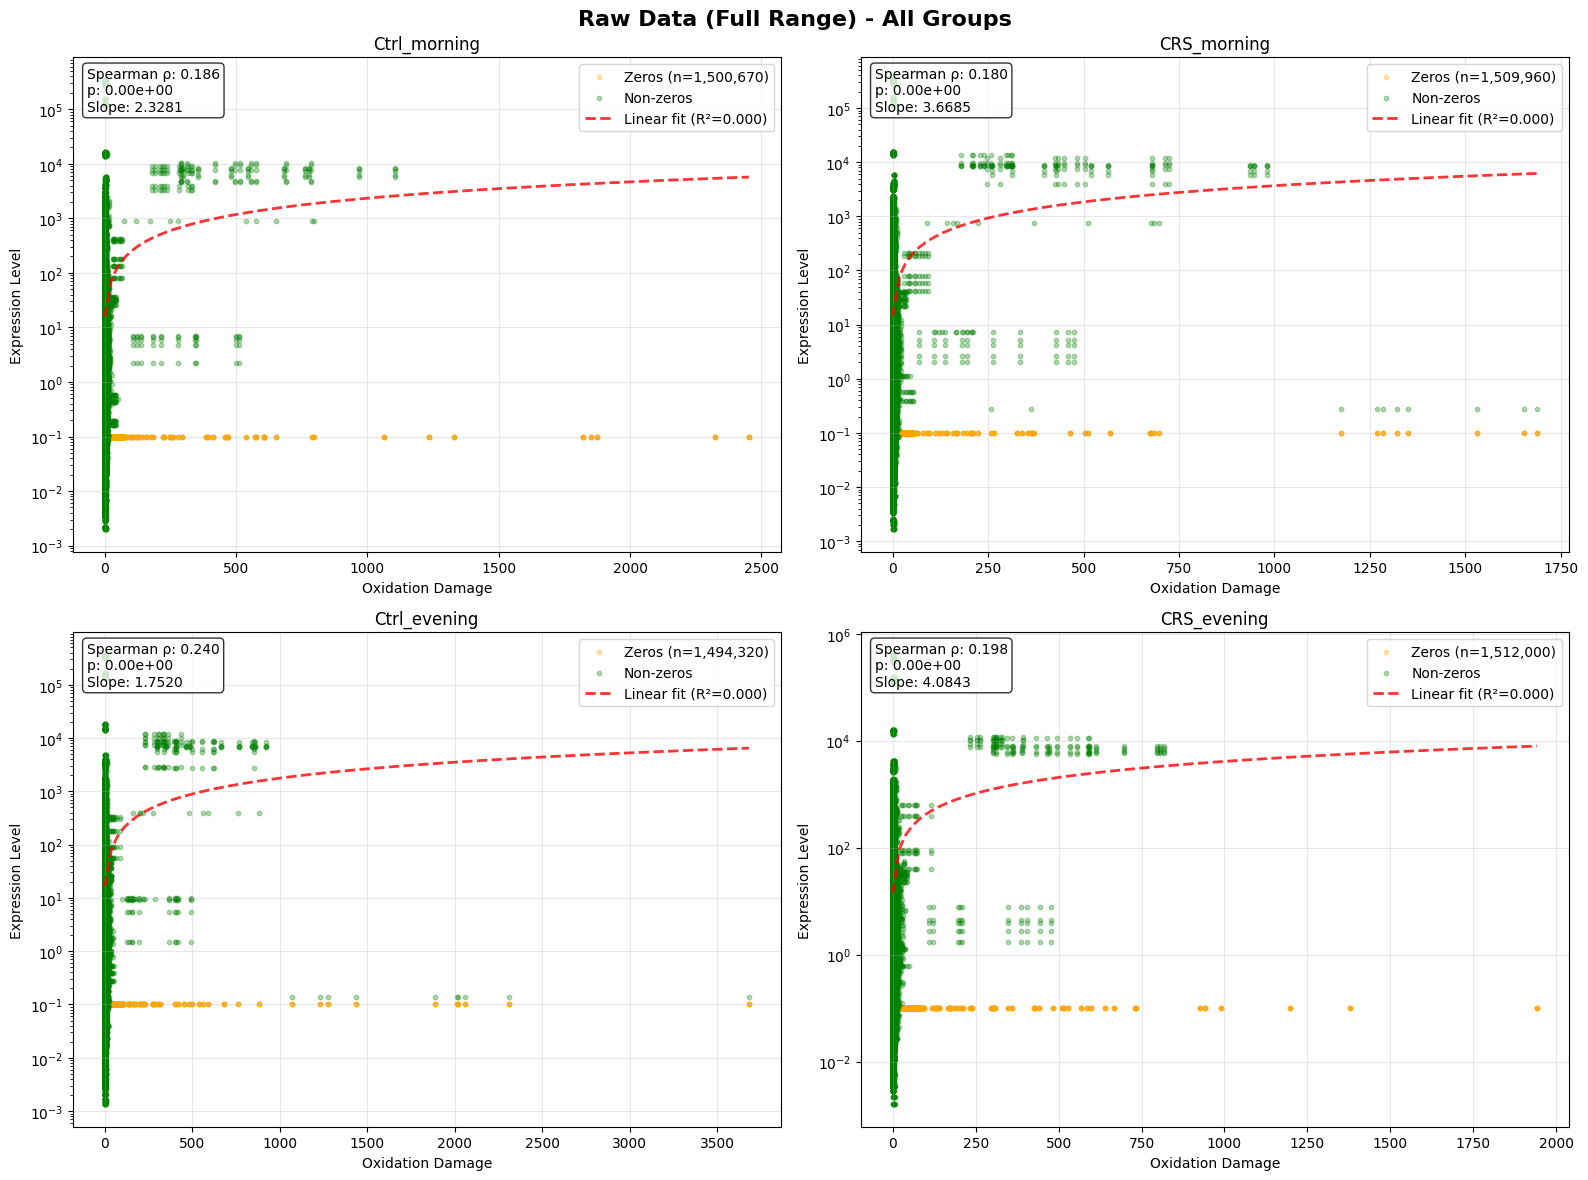

Saved: ../images/expr_global/gene_bodies/raw_data_zoomed.png


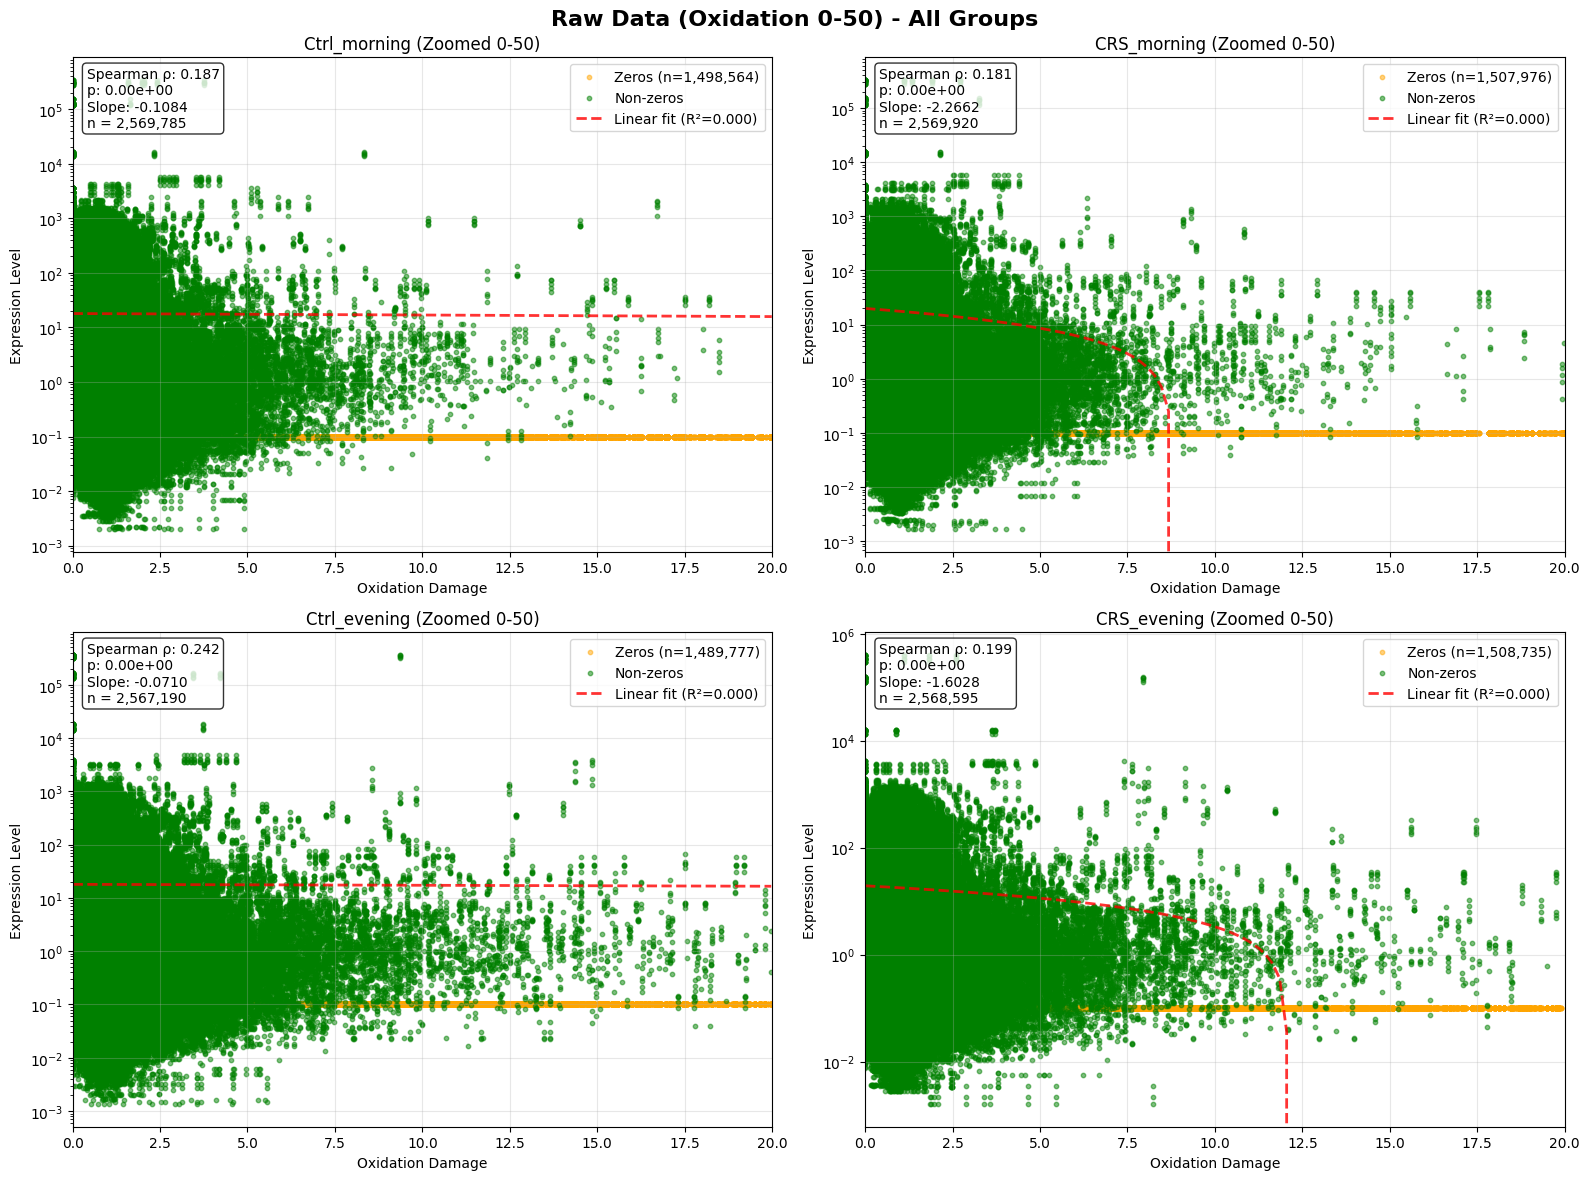


Processing group: Ctrl_morning
Available columns: ['Gene', 'Sample_expr', 'Group', 'Expression_level', 'Sample_oxid', 'median_normalized_damage']
Found 5 unique samples in group Ctrl_morning

Processing group: CRS_morning
Available columns: ['Gene', 'Sample_expr', 'Group', 'Expression_level', 'Sample_oxid', 'median_normalized_damage']
Found 5 unique samples in group CRS_morning

Processing group: Ctrl_evening
Available columns: ['Gene', 'Sample_expr', 'Group', 'Expression_level', 'Sample_oxid', 'median_normalized_damage']
Found 5 unique samples in group Ctrl_evening

Processing group: CRS_evening
Available columns: ['Gene', 'Sample_expr', 'Group', 'Expression_level', 'Sample_oxid', 'median_normalized_damage']
Found 5 unique samples in group CRS_evening

Successfully calculated correlations for 20 samples
Across 4 groups
Average number of genes per sample: 514450.0
Saved: ./plots/spearman_correlation_by_sample.png


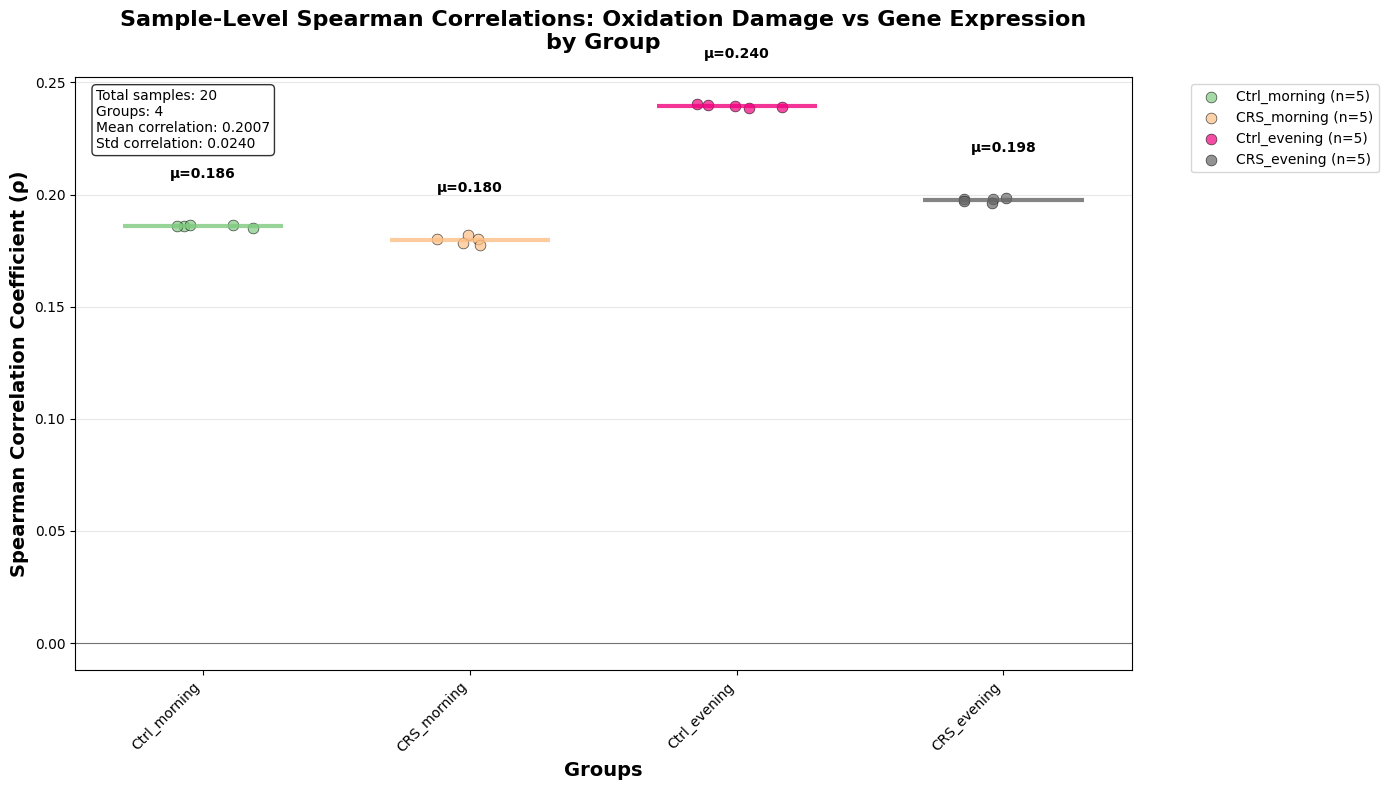


Sample-Level Spearman Correlation Summary:
------------------------------------------------------------

Ctrl_morning:
  Number of samples: 5
  Mean correlation: 0.1859
  Std correlation: 0.0007
  Range: 0.1849 to 0.1866
  Avg genes per sample: 514450.0

CRS_morning:
  Number of samples: 5
  Mean correlation: 0.1797
  Std correlation: 0.0018
  Range: 0.1775 to 0.1822
  Avg genes per sample: 514450.0

Ctrl_evening:
  Number of samples: 5
  Mean correlation: 0.2395
  Std correlation: 0.0007
  Range: 0.2388 to 0.2404
  Avg genes per sample: 514450.0

CRS_evening:
  Number of samples: 5
  Mean correlation: 0.1976
  Std correlation: 0.0011
  Range: 0.1961 to 0.1987
  Avg genes per sample: 514450.0

Analysis complete! Used robust methods appropriate for zero-inflated expression data.


In [59]:
EXPR_PATH = "/nfs/nas12.ethz.ch/fs1201/green_groups_let_public/Euler/Vakil/Mouse_brain_Sept2024/gene_annotation2/CRS_Morning_Evening_TPM_rearr.csv"
OXID_PATH = "../data_normalized/gene_bodies_Normalized.csv"
SAVE_PATH_GENE = "../images/expr_global/gene_bodies"
SAVE_PATH_PRO = "../images/expr_global/promoters"

expr_df, oxid_df = load_data(EXPR_PATH, OXID_PATH)
        
# Merge data
merged_df = merge_data_for_correlation(expr_df, oxid_df)
        
# Detailed zero inflation analysis
analysis_results = analyze_zero_inflation_detailed(merged_df)
        
# Robust correlation analysis (avoiding problematic Poisson regression)
correlation_results = robust_correlation_analysis(analysis_results)
        
# Create robust visualizations
create_robust_visualizations_separate_rows(analysis_results, correlation_results, SAVE_PATH_GENE)
        
# Print final summary
sample_corr_df = plot_spearman_by_sample(analysis_results, correlation_results )
        
print(f"\nAnalysis complete! Used robust methods appropriate for zero-inflated expression data.")


Loading expression data...
Loading oxidation data...
Expression data shape: (1052980, 5)
Oxidation data shape: (3128080, 11)
Using gene column 'Gene' from expression data
Using gene column 'gene' from oxidation data
Merged data shape: (10408200, 6)
Groups found: ['Ctrl_morning' 'CRS_morning' 'Ctrl_evening' 'CRS_evening']

DETAILED ZERO INFLATION ANALYSIS

Group: Ctrl_morning
Total data points: 2,602,050
Zero expression points: 1,530,430
Zero inflation: 58.8%
Expression range: 0.00 - 347592.22
Expression mean: 18.07
Oxidation range: 0.0000 - 927.4174
Oxidation mean: 0.9877

Group: CRS_morning
Total data points: 2,602,050
Zero expression points: 1,539,700
Zero inflation: 59.2%
Expression range: 0.00 - 332779.55
Expression mean: 18.05
Oxidation range: 0.0000 - 839.3028
Oxidation mean: 0.9979

Group: Ctrl_evening
Total data points: 2,602,050
Zero expression points: 1,524,050
Zero inflation: 58.6%
Expression range: 0.00 - 364508.86
Expression mean: 18.09
Oxidation range: 0.0000 - 946.4799
O

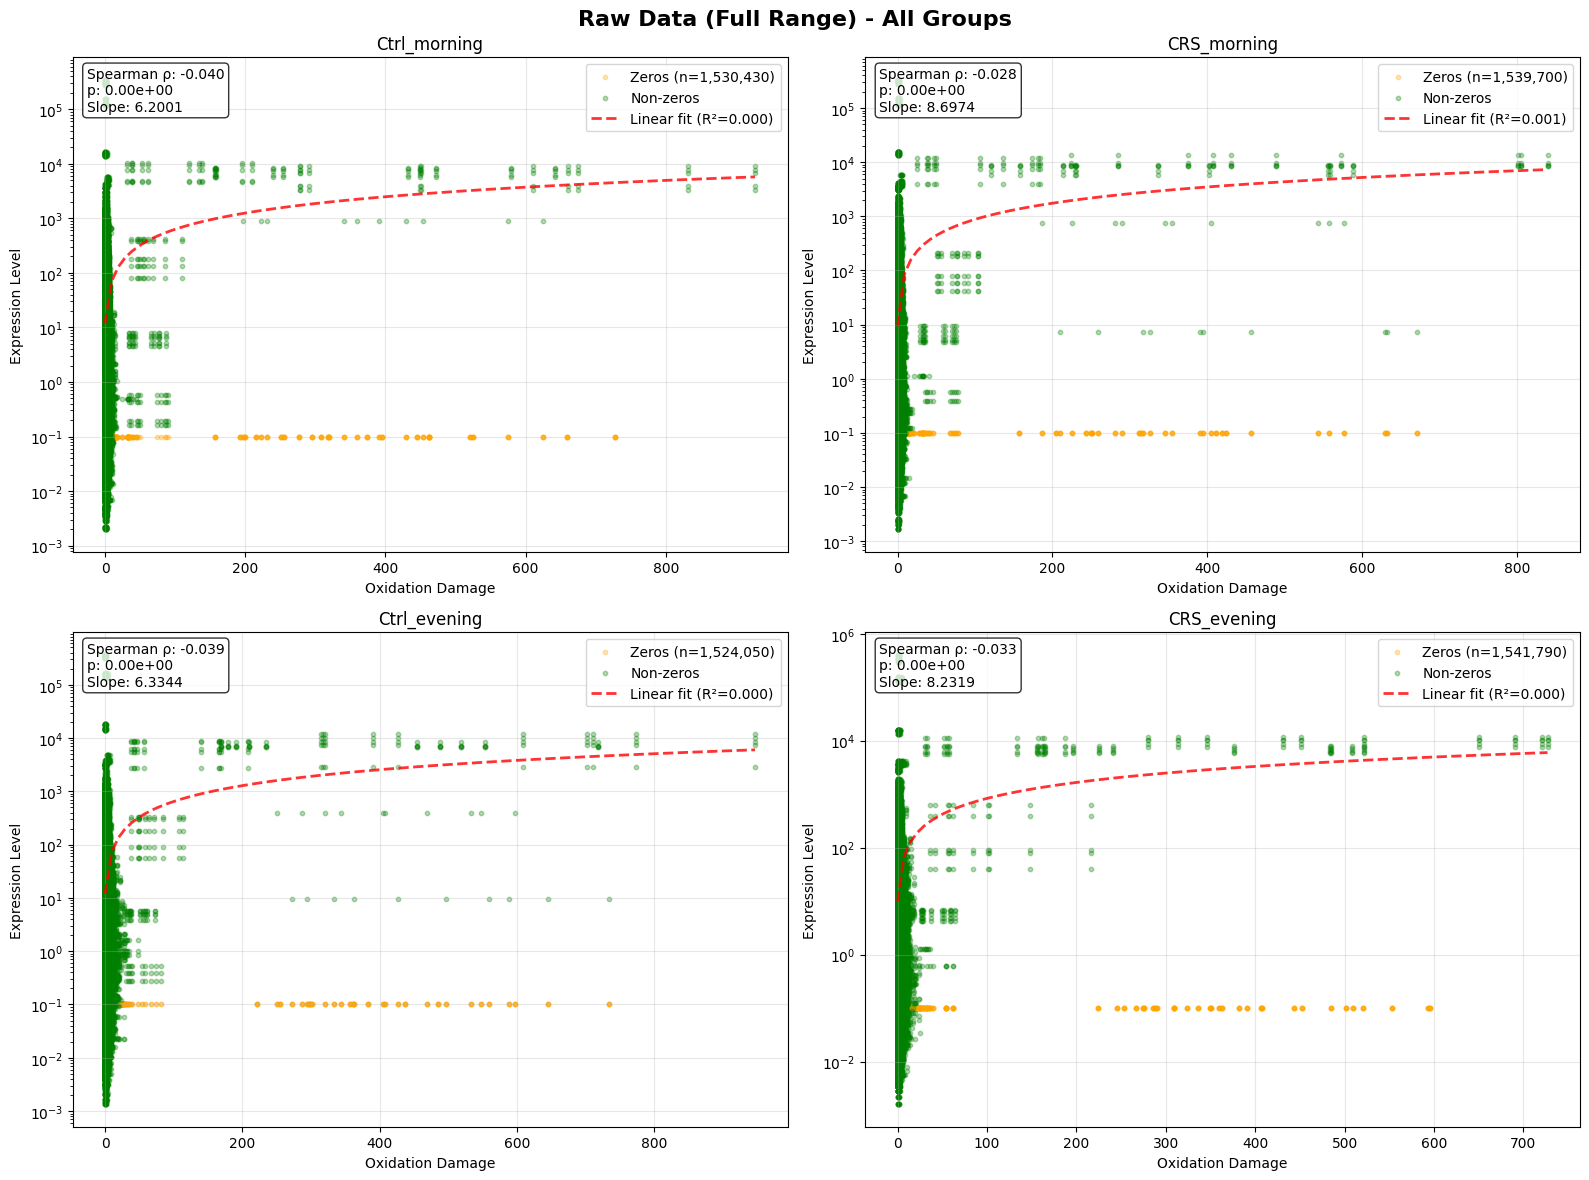

Saved: ../images/expr_global/promoters/raw_data_zoomed.png


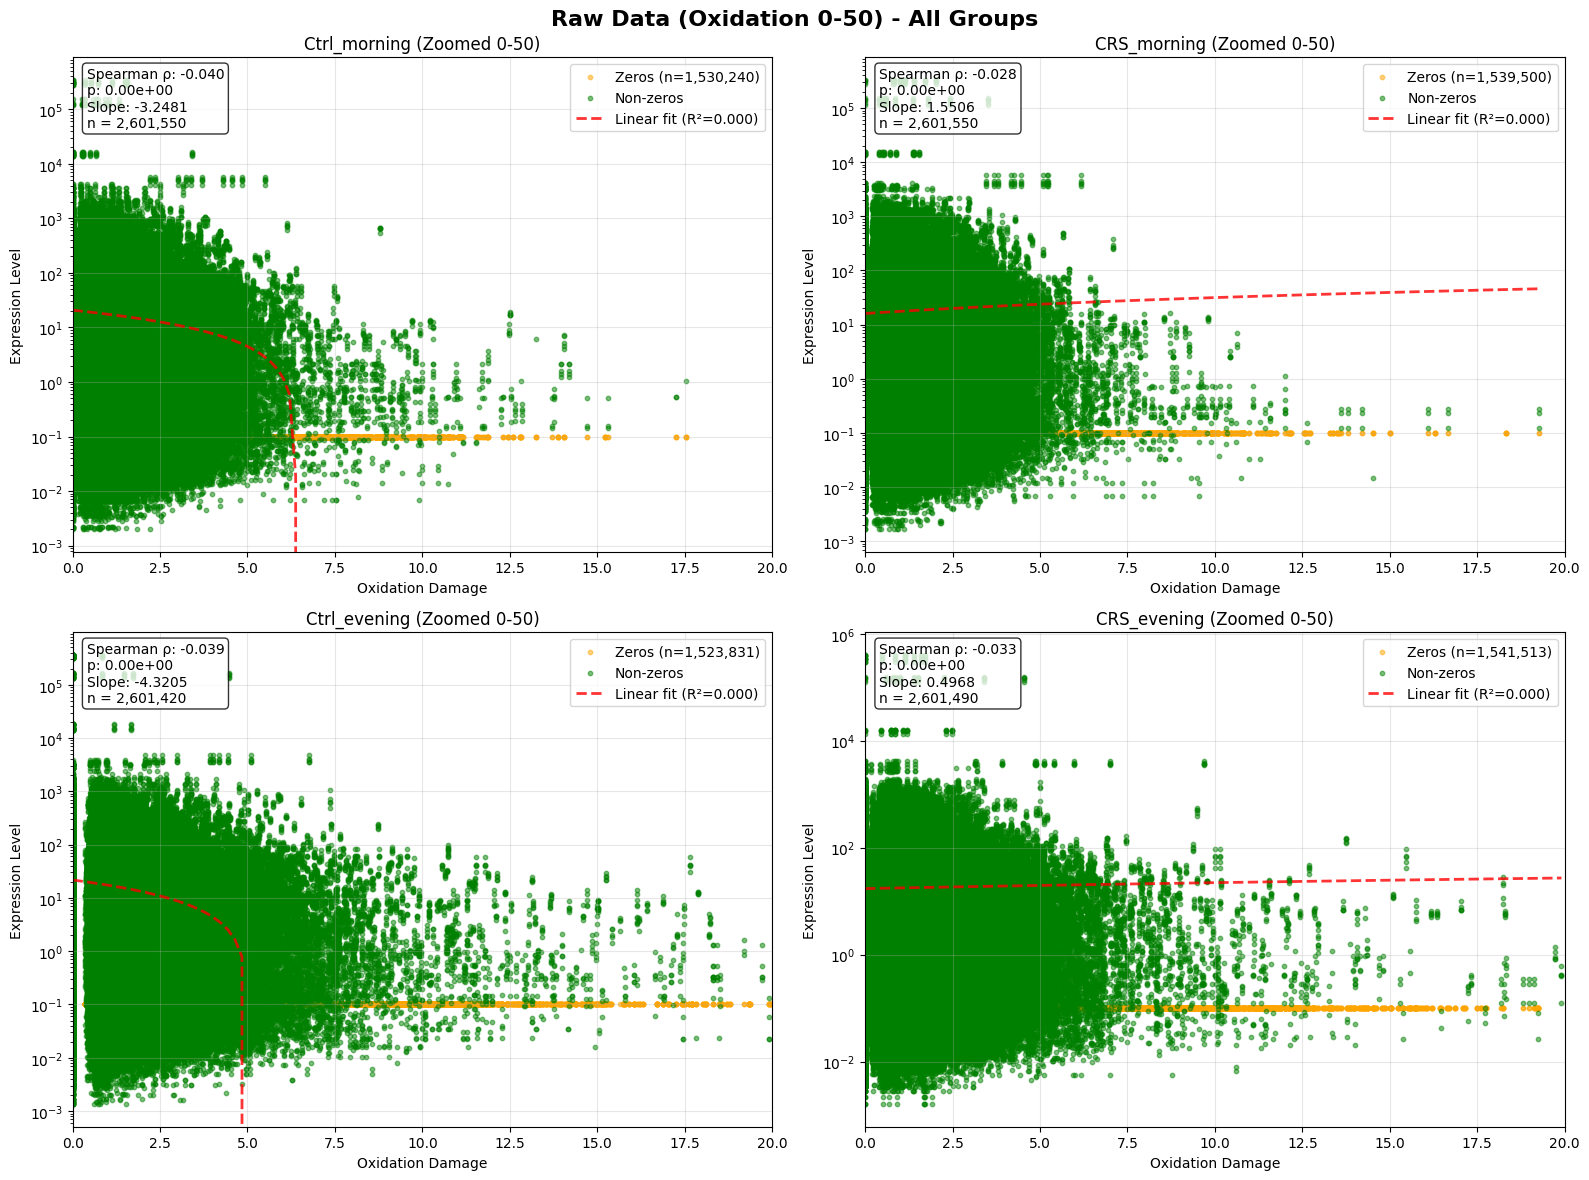


Processing group: Ctrl_morning
Available columns: ['Gene', 'Sample_expr', 'Group', 'Expression_level', 'Sample_oxid', 'median_normalized_damage']
Found 5 unique samples in group Ctrl_morning

Processing group: CRS_morning
Available columns: ['Gene', 'Sample_expr', 'Group', 'Expression_level', 'Sample_oxid', 'median_normalized_damage']
Found 5 unique samples in group CRS_morning

Processing group: Ctrl_evening
Available columns: ['Gene', 'Sample_expr', 'Group', 'Expression_level', 'Sample_oxid', 'median_normalized_damage']
Found 5 unique samples in group Ctrl_evening

Processing group: CRS_evening
Available columns: ['Gene', 'Sample_expr', 'Group', 'Expression_level', 'Sample_oxid', 'median_normalized_damage']
Found 5 unique samples in group CRS_evening

Successfully calculated correlations for 20 samples
Across 4 groups
Average number of genes per sample: 520410.0
Saved: ./plots/spearman_correlation_by_sample.png


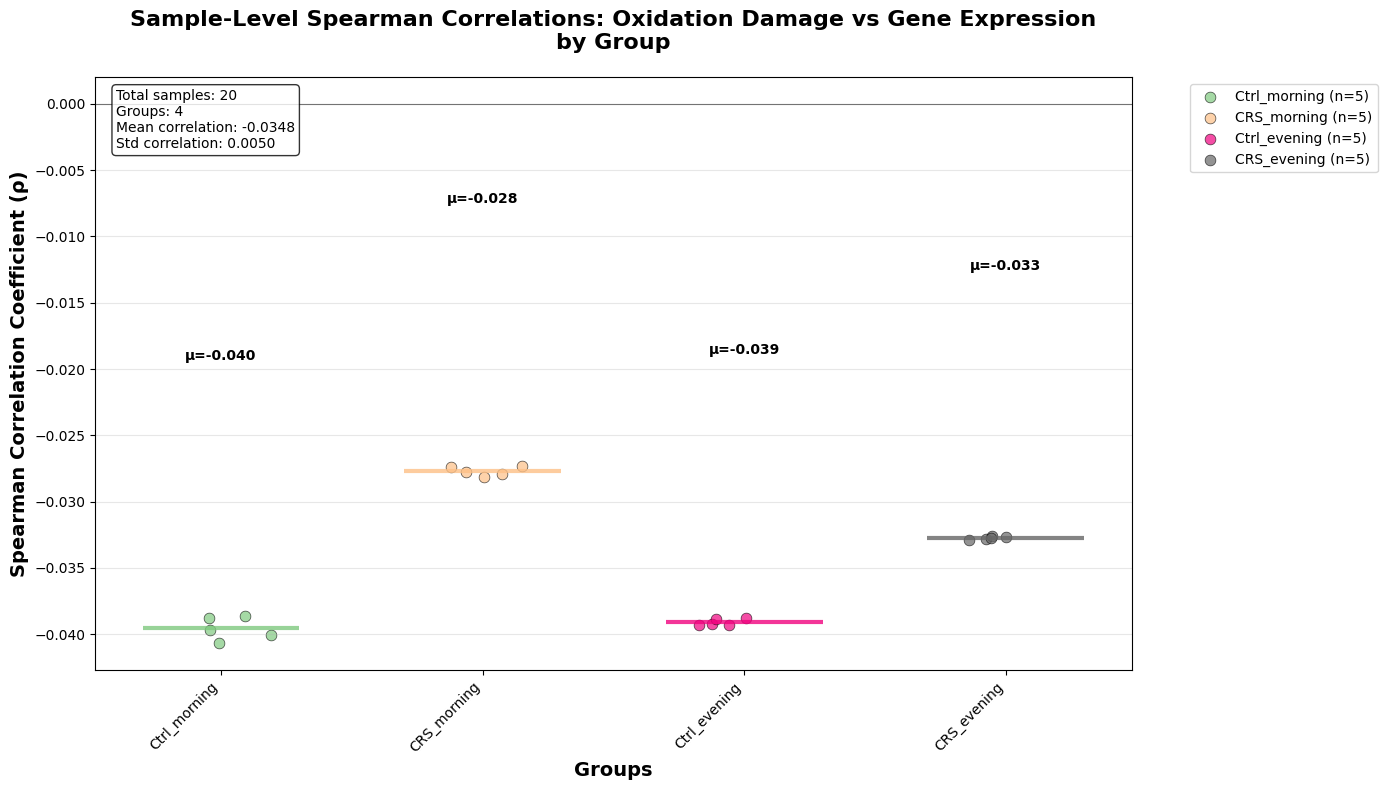


Sample-Level Spearman Correlation Summary:
------------------------------------------------------------

Ctrl_morning:
  Number of samples: 5
  Mean correlation: -0.0396
  Std correlation: 0.0009
  Range: -0.0407 to -0.0386
  Avg genes per sample: 520410.0

CRS_morning:
  Number of samples: 5
  Mean correlation: -0.0277
  Std correlation: 0.0004
  Range: -0.0281 to -0.0273
  Avg genes per sample: 520410.0

Ctrl_evening:
  Number of samples: 5
  Mean correlation: -0.0391
  Std correlation: 0.0003
  Range: -0.0393 to -0.0388
  Avg genes per sample: 520410.0

CRS_evening:
  Number of samples: 5
  Mean correlation: -0.0328
  Std correlation: 0.0001
  Range: -0.0329 to -0.0326
  Avg genes per sample: 520410.0

Analysis complete! Used robust methods appropriate for zero-inflated expression data.


In [60]:
EXPR_PATH = "/nfs/nas12.ethz.ch/fs1201/green_groups_let_public/Euler/Vakil/Mouse_brain_Sept2024/gene_annotation2/CRS_Morning_Evening_TPM_rearr.csv"
OXID_PATH = "../data_normalized/promoters_Normalized.csv"
SAVE_PATH_GENE = "../images/expr_global/gene_bodies"
SAVE_PATH_PRO = "../images/expr_global/promoters"

expr_df, oxid_df = load_data(EXPR_PATH, OXID_PATH)
        
# Merge data
merged_df = merge_data_for_correlation(expr_df, oxid_df)
        
# Detailed zero inflation analysis
analysis_results = analyze_zero_inflation_detailed(merged_df)
        
# Robust correlation analysis (avoiding problematic Poisson regression)
correlation_results = robust_correlation_analysis(analysis_results)
        
# Create robust visualizations
create_robust_visualizations_separate_rows(analysis_results, correlation_results,SAVE_PATH_PRO )
        
# Print final summary
sample_corr_df = plot_spearman_by_sample(analysis_results, correlation_results )
        
print(f"\nAnalysis complete! Used robust methods appropriate for zero-inflated expression data.")

Loading expression data...
Loading oxidation data...
Expression data shape: (1052980, 5)
Oxidation data shape: (840400, 11)
Using gene column 'Gene' from expression data
Using gene column 'gene' from oxidation data
Merged data shape: (2666000, 6)
Groups found: ['Ctrl_morning' 'CRS_morning' 'Ctrl_evening' 'CRS_evening']

DETAILED ZERO INFLATION ANALYSIS

Group: Ctrl_morning
Total data points: 666,500
Zero expression points: 84,940
Zero inflation: 12.7%
Expression range: 0.00 - 347592.22
Expression mean: 58.73
Oxidation range: 0.0000 - 98.6318
Oxidation mean: 0.4763

Group: CRS_morning
Total data points: 666,500
Zero expression points: 86,950
Zero inflation: 13.0%
Expression range: 0.00 - 332779.55
Expression mean: 58.39
Oxidation range: 0.0000 - 105.4166
Oxidation mean: 0.5563

Group: Ctrl_evening
Total data points: 666,500
Zero expression points: 83,790
Zero inflation: 12.6%
Expression range: 0.00 - 364508.86
Expression mean: 59.87
Oxidation range: 0.0000 - 111.7365
Oxidation mean: 0.5

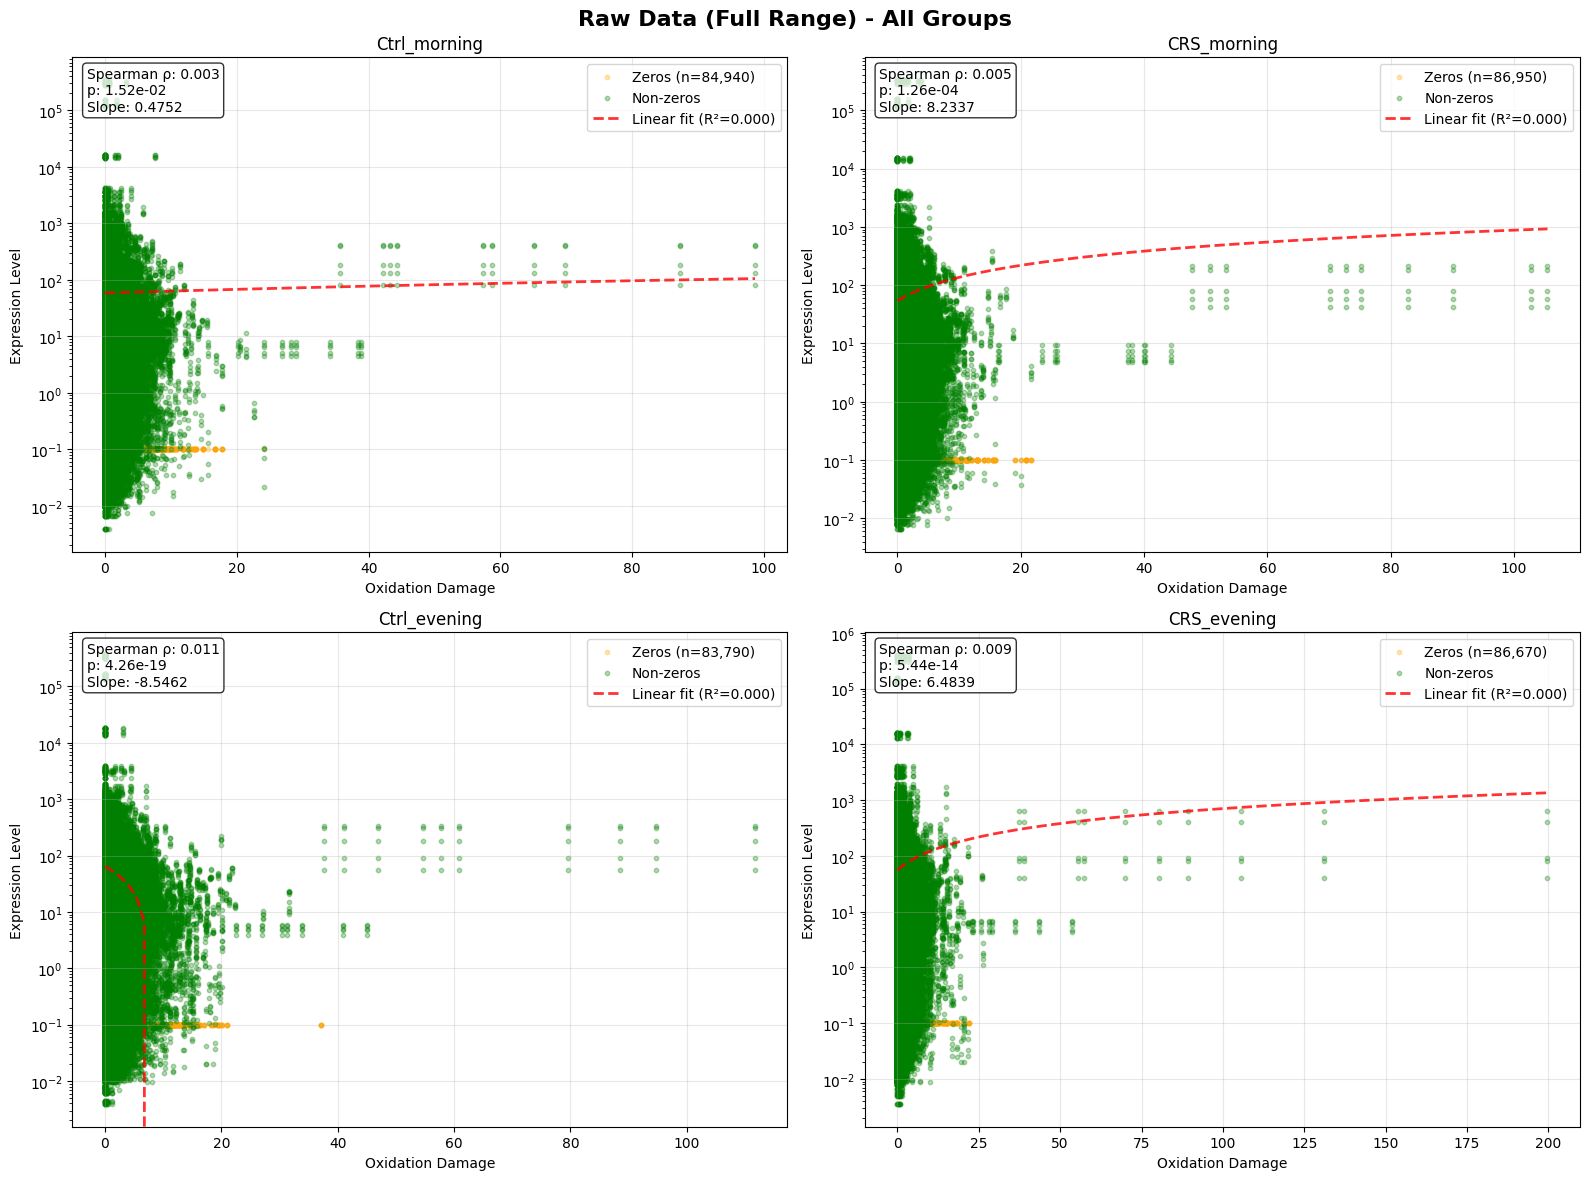

Saved: ../images/expr_global/promoters/raw_data_zoomed.png


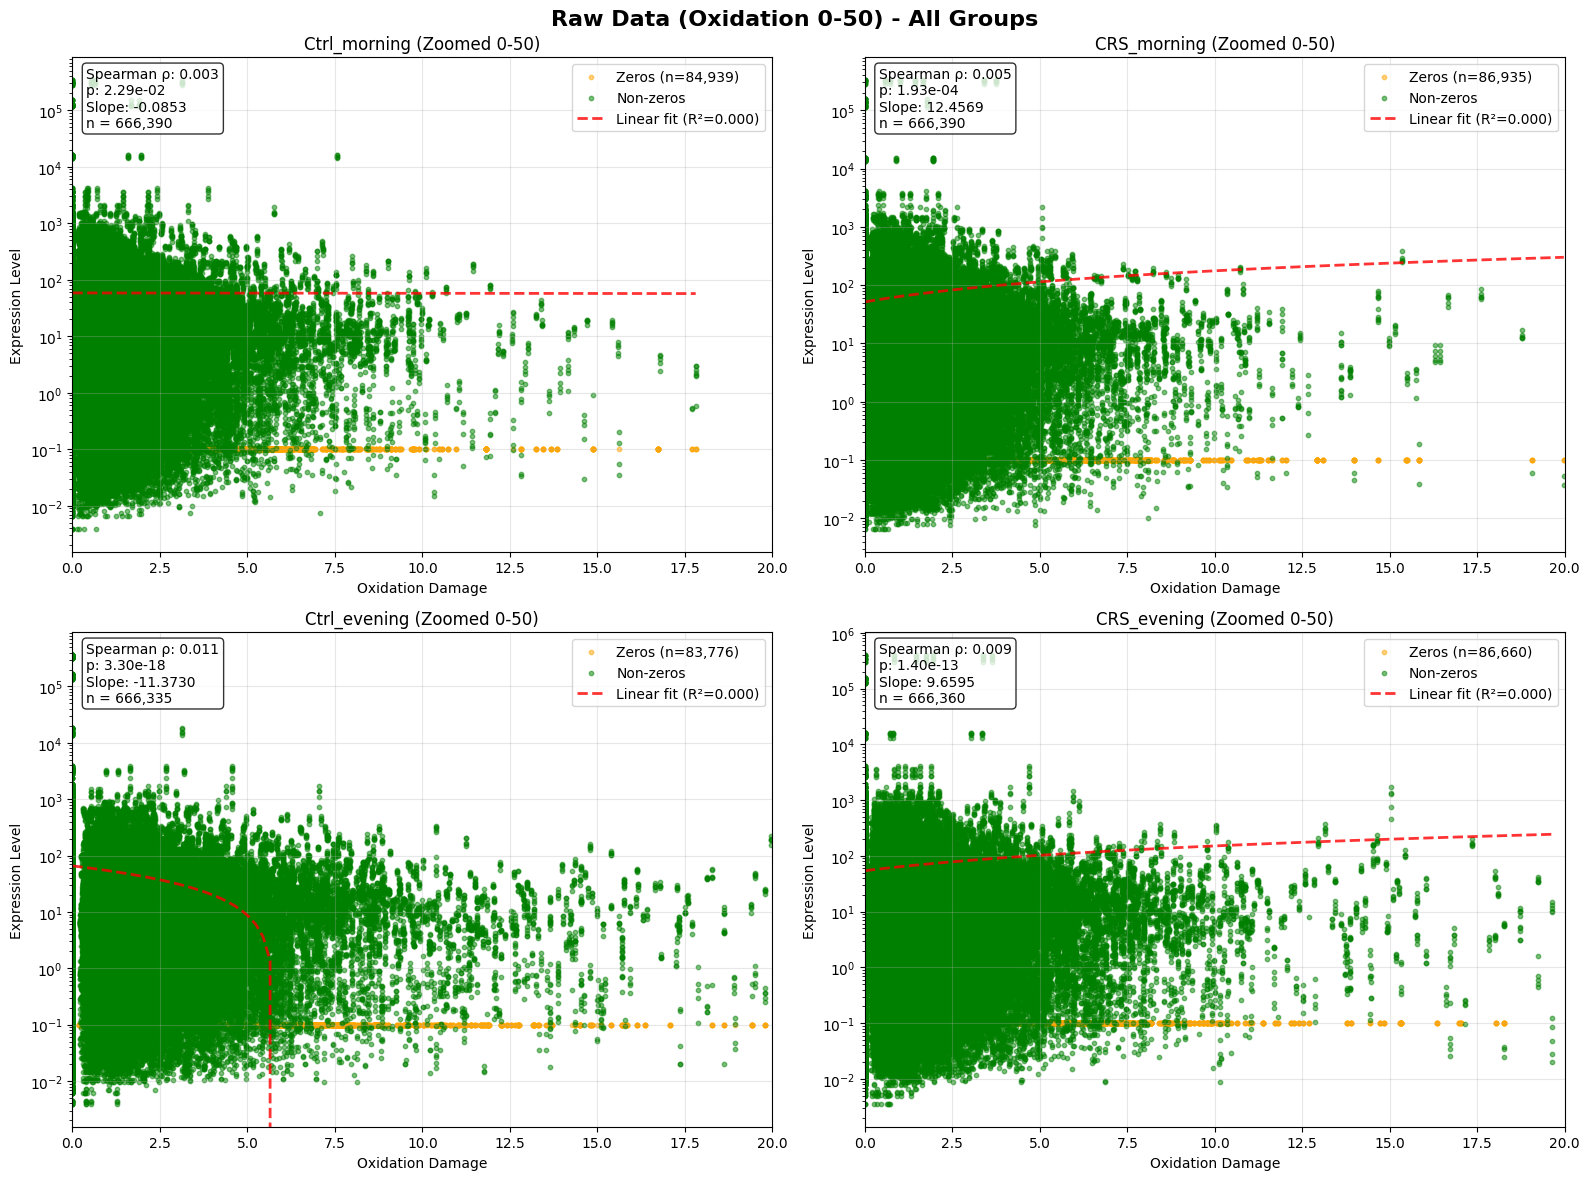


Processing group: Ctrl_morning
Available columns: ['Gene', 'Sample_expr', 'Group', 'Expression_level', 'Sample_oxid', 'median_normalized_damage']
Found 5 unique samples in group Ctrl_morning

Processing group: CRS_morning
Available columns: ['Gene', 'Sample_expr', 'Group', 'Expression_level', 'Sample_oxid', 'median_normalized_damage']
Found 5 unique samples in group CRS_morning

Processing group: Ctrl_evening
Available columns: ['Gene', 'Sample_expr', 'Group', 'Expression_level', 'Sample_oxid', 'median_normalized_damage']
Found 5 unique samples in group Ctrl_evening

Processing group: CRS_evening
Available columns: ['Gene', 'Sample_expr', 'Group', 'Expression_level', 'Sample_oxid', 'median_normalized_damage']
Found 5 unique samples in group CRS_evening

Successfully calculated correlations for 20 samples
Across 4 groups
Average number of genes per sample: 133300.0
Saved: ./plots/spearman_correlation_by_sample.png


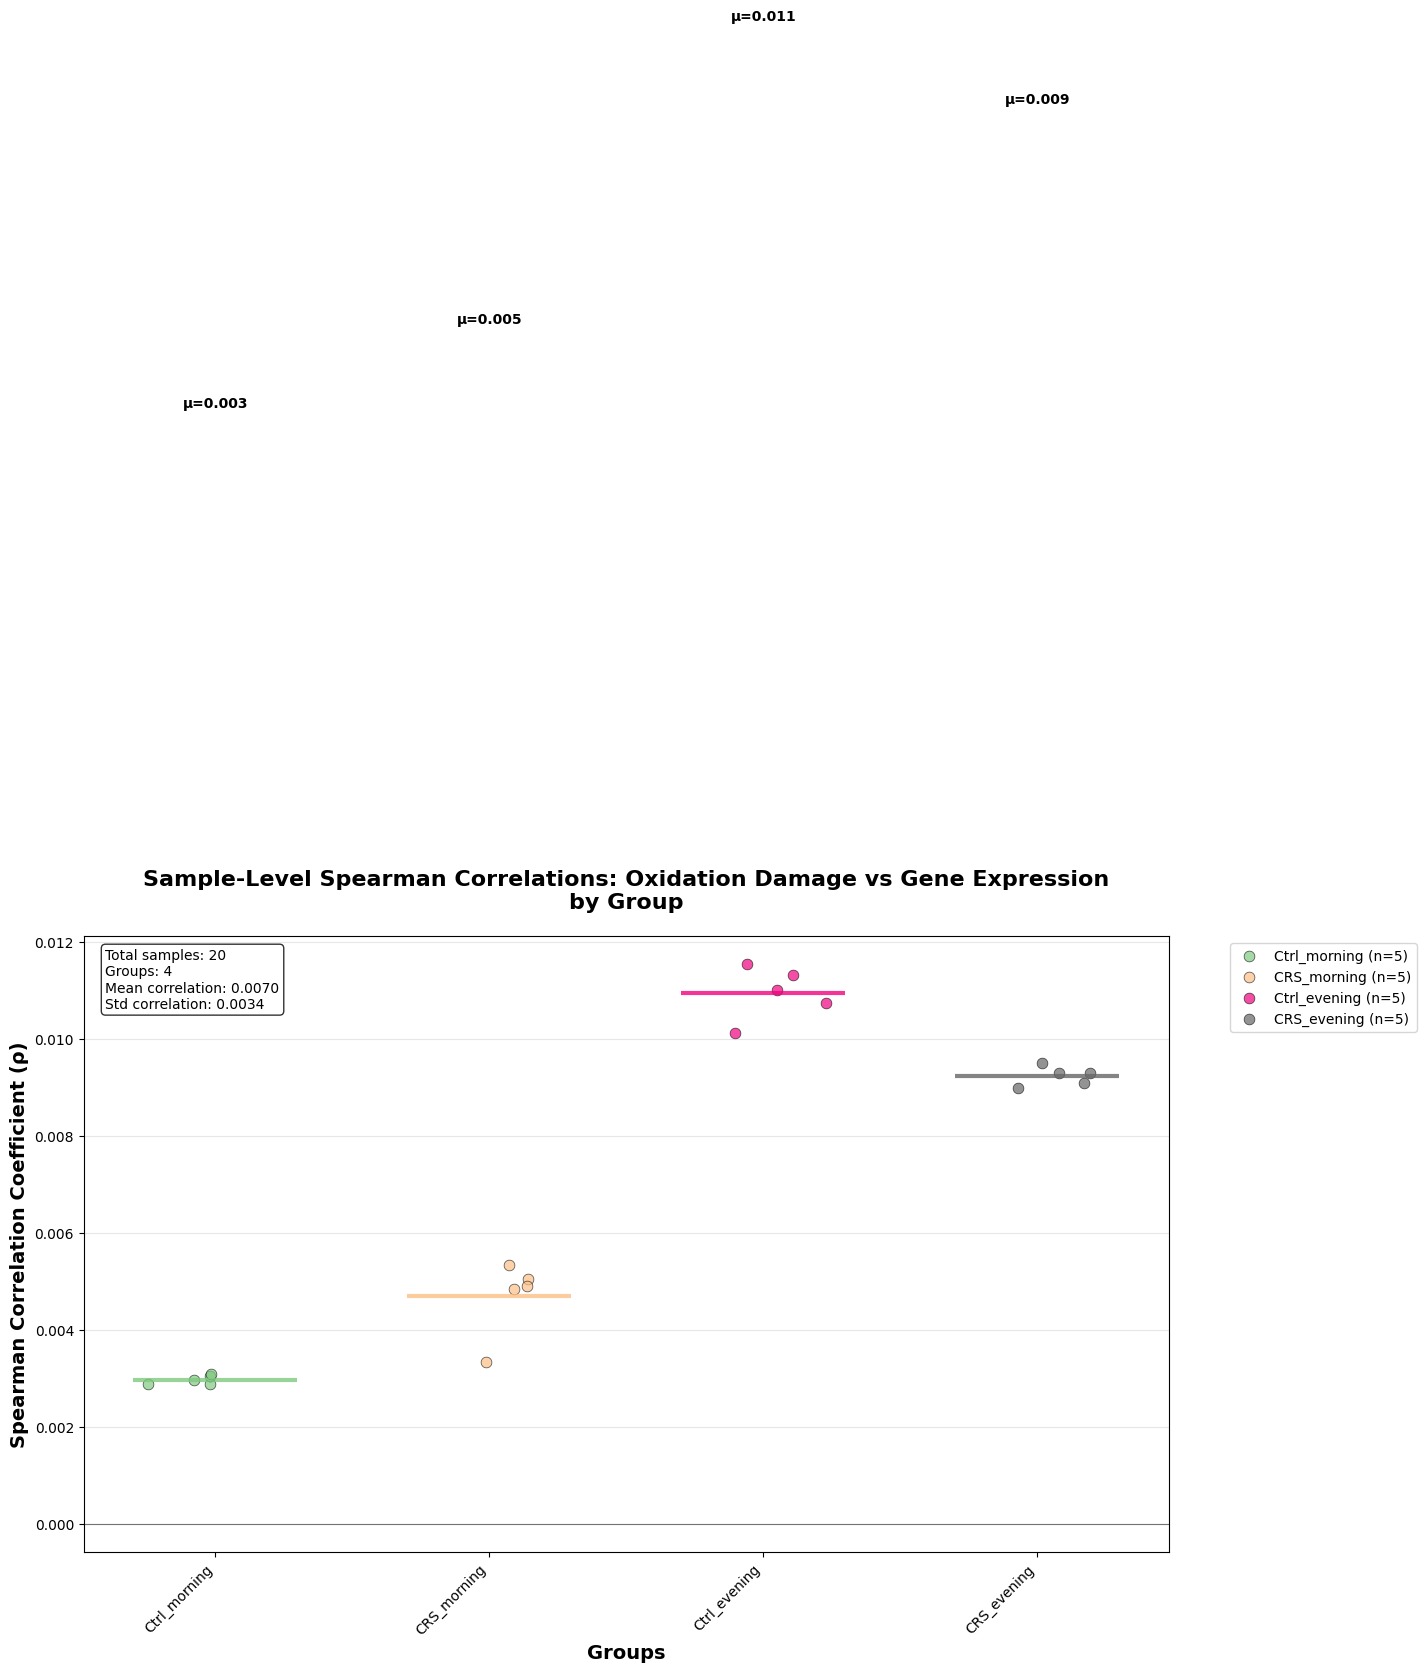


Sample-Level Spearman Correlation Summary:
------------------------------------------------------------

Ctrl_morning:
  Number of samples: 5
  Mean correlation: 0.0030
  Std correlation: 0.0001
  Range: 0.0029 to 0.0031
  Avg genes per sample: 133300.0

CRS_morning:
  Number of samples: 5
  Mean correlation: 0.0047
  Std correlation: 0.0008
  Range: 0.0033 to 0.0053
  Avg genes per sample: 133300.0

Ctrl_evening:
  Number of samples: 5
  Mean correlation: 0.0110
  Std correlation: 0.0006
  Range: 0.0101 to 0.0115
  Avg genes per sample: 133300.0

CRS_evening:
  Number of samples: 5
  Mean correlation: 0.0092
  Std correlation: 0.0002
  Range: 0.0090 to 0.0095
  Avg genes per sample: 133300.0

Analysis complete! Used robust methods appropriate for zero-inflated expression data.


In [61]:
EXPR_PATH = "/nfs/nas12.ethz.ch/fs1201/green_groups_let_public/Euler/Vakil/Mouse_brain_Sept2024/gene_annotation2/CRS_Morning_Evening_TPM_rearr.csv"
OXID_PATH = "../data_normalized/cpg_Normalized_with_genes.csv"
SAVE_PATH_GENE = "../images/expr_global/gene_bodies"
SAVE_PATH_PRO = "../images/expr_global/promoters"

expr_df, oxid_df = load_data(EXPR_PATH, OXID_PATH)
        
# Merge data
merged_df = merge_data_for_correlation(expr_df, oxid_df)
        
# Detailed zero inflation analysis
analysis_results = analyze_zero_inflation_detailed(merged_df)
        
# Robust correlation analysis (avoiding problematic Poisson regression)
correlation_results = robust_correlation_analysis(analysis_results)
        
# Create robust visualizations
create_robust_visualizations_separate_rows(analysis_results, correlation_results,SAVE_PATH_PRO )
        
# Print final summary
sample_corr_df = plot_spearman_by_sample(analysis_results, correlation_results )
        
print(f"\nAnalysis complete! Used robust methods appropriate for zero-inflated expression data.")